<a href="https://colab.research.google.com/github/tanskanentopias/Koneoppiminen_projekti/blob/main/Syksy2024_projektitehtava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


In [145]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [146]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_2 (Normalization)      │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [147]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)





In [148]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [149]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



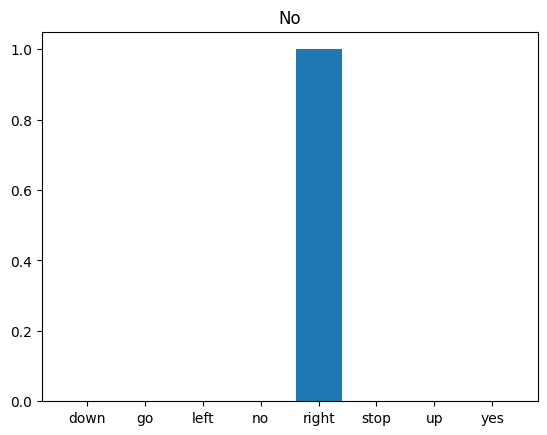

In [150]:
#x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = data_dir/'right/0d2bcf9d_nohash_2.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
#x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
#x_labels = [label_names]
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [164]:
print(get_weights_shape(get_layer_weights("conv2d_4",model)))
weights = get_layer_weights("conv2d_4",model)

[(3, 3, 1, 32), (32,)]


In [165]:
def conv2d_1(input, weights):
  if isinstance(input, tf.Tensor):
    input = input.numpy()  # Convert tensor to numpy if it's a tensor

    #Filter dimensions and channels from weights
    filter_height = weights[0].shape[0]
    filter_width = weights[0].shape[1]
    input_channel = weights[0].shape[2]
    output_channel = weights[0].shape[3]

    #input
    input_h = input.shape[1]
    input_w = input.shape[2]
    filters = weights[0]
    biases = weights[1]

    output = np.zeros([input.shape[0], input_h - 2, input_w - 2, output_channel])

    for n in range(input.shape[0]):  # Batch size
        for out_c in range(output_channel):  # Output channels
            for in_c in range(input_channel):  # Input channels
                for i in range(input_h - filter_height + 1): #30 - 3 + 1 =28
                    for j in range(input_w - filter_width + 1): #30 - 3 + 1 =28

                        patch = input[n, i:i+filter_height, j:j+filter_width, in_c]

                        #convolution
                        output[n, i, j, out_c] += np.sum(patch * filters[:, :, in_c, out_c])


            output[n, :, :, out_c] += biases[out_c] #adding bias
            output[n, :, :, out_c] = np.maximum(output[n, :, :, out_c], 0) #ReLU
    print("input_h = ", input_h)
    print("input_w = ", input_w)
    #print("Tulos shape:", output.shape)
    #print("Tulos =", output)
    return output


In [153]:
print(get_weights_shape(get_layer_weights("conv2d_5",model)))
weights = get_layer_weights("conv2d_5",model)

[(3, 3, 32, 64), (64,)]


In [154]:
def conv2d_2(input, weights):
    input = input.numpy()  # Convert tensor to numpy if it's a tensor

    # Get filter dimensions and channels
    filter_height = weights[0].shape[0]
    filter_width = weights[0].shape[1]
    input_channel = weights[0].shape[2]
    output_channel = weights[0].shape[3]

    input_h = input.shape[1]
    input_w = input.shape[2]
    #print("input_h = ", input_h)
    #print("input_w = ", input_w)
    # Extract the filters and biases
    filters = weights[0]
    biases = weights[1]

    # Initialize the output tensor with the correct dimensions
    output = np.zeros([input.shape[0], input_h - 2, input_w - 2, output_channel])

    # Perform the convolution operation
    for n in range(input.shape[0]):  # Batch size
        for out_c in range(output_channel):  # Output channels
            for in_c in range(input_channel):  # Input channels
                for i in range(input_h - filter_height + 1):
                    for j in range(input_w - filter_width + 1):
                        # Extract the 3x3 patch from the input for this position
                        patch = input[n, i:i+filter_height, j:j+filter_width, in_c]

                        # Perform the convolution (element-wise multiplication and sum)
                        output[n, i, j, out_c] += np.sum(patch * filters[:, :, in_c, out_c])

            # Add bias for each output channel
            output[n, :, :, out_c] += biases[out_c]
            output[n, :, :, out_c] = np.maximum(output[n, :, :, out_c], 0)
    print("input_h = ", input_h)
    print("input_w = ", input_w)
    #print("Tulos shape:", output.shape)
    #print("Tulos =", output)
    return output

conv2d_2(input, weights)

input_h =  30
input_w =  30


array([[[[0.        , 0.        , 0.        , ..., 1.07252971,
          2.09553338, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.2855826 ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 1.33213143,
          2.10644748, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0. 

In [155]:


'''def conv2d_2(input_tensor, weights):
  input_tensor = input_tensor.numpy()

  filter_h, filter_w, input_channels, output_channels = weights[0].shape

  batch_size = input_tensor.shape[0]
  input_h = input_tensor.shape[1]
  input_w = input_tensor.shape[2]
  #input_kuva = input_tensor.shape[3]

  filters = np.array((weights[0]))
  biases = weights[1]

  output_h = input_h - filter_h + 1
  output_w = input_w - filter_w + 1

  output = np.zeros((batch_size, output_h, output_w, output_channels))

  print(input_h)
  print(input_w)
  print(input_channels)
  print(output_channels)
  print(filter)
  print(biases)


  print(output)



  for o in range(output_channels):
    for i in range(input_channels):
      for h in range(output_h):
        for w in range(output_w):

          patch = input_tensor[0, h:h+filter_h, w:w+filter_w, i]
                    # Convolve the patch with the filter
          output[0, h, w, o] += np.sum(patch * filters[:, :, i, o])

        # Add the bias for each output channel
        output[:, :, :, o] += biases[o]

    print(output)
    return output


input_tensor = x

conv2d_2(input_tensor, weights)
'''

'def conv2d_2(input_tensor, weights):\n  input_tensor = input_tensor.numpy()\n\n  filter_h, filter_w, input_channels, output_channels = weights[0].shape\n  \n  batch_size = input_tensor.shape[0]\n  input_h = input_tensor.shape[1]\n  input_w = input_tensor.shape[2]\n  #input_kuva = input_tensor.shape[3]\n\n  filters = np.array((weights[0]))\n  biases = weights[1]\n  \n  output_h = input_h - filter_h + 1\n  output_w = input_w - filter_w + 1\n\n  output = np.zeros((batch_size, output_h, output_w, output_channels))\n\n  print(input_h)\n  print(input_w)\n  print(input_channels)\n  print(output_channels)\n  print(filter)\n  print(biases)\n  \n\n  print(output)\n\n  \n\n  for o in range(output_channels):\n    for i in range(input_channels):\n      for h in range(output_h):\n        for w in range(output_w):\n          \n          patch = input_tensor[0, h:h+filter_h, w:w+filter_w, i]\n                    # Convolve the patch with the filter\n          output[0, h, w, o] += np.sum(patch * filt

In [156]:
'''def ReLU(x):
    return (x>0)*x

print(ReLU(-56))'''


def maxPooling(input, pool_size=(2,2), strides=(2,2)):
    output_height = int((input.shape[1] - pool_size[0]) / strides[0]) + 1
    output_width = int((input.shape[2] - pool_size[1]) / strides[1]) + 1
    output = np.zeros((input.shape[0], output_height, output_width, input.shape[3]))

    '''testArray = np.array([[2, 2, 7, 3],
    [9, 4, 6, 1],
    [8, 5, 2, 4],
    [3, 1, 2, 6]])'''

    for i in range(output_height):
        for j in range(output_width):
            h_start = i * strides[0]
            h_end = h_start + pool_size[0]
            w_start = j * strides[1]
            w_end = w_start + pool_size[1]
            output[:, i, j, :] = np.max(input[:, h_start:h_end, w_start:w_end, :], axis=(1, 2))
            #output[:, i, j, :] = np.max(testArray[h_start:h_end, w_start:w_end], axis=(1, 2))

    return output



In [157]:


def dense1(input, weights, biases):
    input = input.numpy()
    num_outputs = biases.shape[0]
    tulos = np.zeros(num_outputs)
    for n in range(num_outputs):
        for w in range(weights.shape[0]):
            tulos[n] += input[0, w] * weights[w, n]
        tulos[n] += biases[n]
    print(tulos)
    (tulos > 0) * tulos #Toimii ReLUna eli muuttaa negatiiviset nolliksi
    return tulos

In [158]:


def omaDense2(input, weights, biases):
    input = input.numpy()
    num_outputs = biases.shape[0]
    tulos = np.zeros(num_outputs)
    for n in range(num_outputs):
        for w in range(weights.shape[0]):
            tulos[n] += input[0, w] * weights[w, n]
        tulos[n] += biases[n]
    print(input, weights, biases)
    print(tulos)
    return tulos





In [166]:
(start, layer, end) = get_reference_layer("conv2d_4", model)



result = start(x)

layer_result = layer(result)
input = result
#biases = weights[1]
oma_result = conv2d_1(input, weights)



#print(result.shape)

oma_result_tf = tf.convert_to_tensor(oma_result, dtype=tf.float32)
print("mallin tulos: ", layer_result)
#print("oma tulos: ", oma_result)

print("Oma tulos: ", oma_result_tf)
#print("oma shape: ",oma_result_tf.shape)


input_h =  32
input_w =  32
mallin tulos:  tf.Tensor(
[[[[1.7221448e-01 1.0283795e-02 3.0176401e-01 ... 6.1831653e-02
    0.0000000e+00 0.0000000e+00]
   [7.5637236e-02 0.0000000e+00 1.6231731e-01 ... 1.2731169e-01
    9.1103397e-02 0.0000000e+00]
   [3.1662282e-02 0.0000000e+00 0.0000000e+00 ... 3.3475488e-02
    4.9944088e-02 3.2975547e-02]
   ...
   [5.1728208e-02 0.0000000e+00 0.0000000e+00 ... 3.9527766e-02
    4.6869203e-02 3.5252191e-02]
   [5.0617136e-02 0.0000000e+00 0.0000000e+00 ... 3.9707307e-02
    4.8794776e-02 3.5420265e-02]
   [4.9859084e-02 0.0000000e+00 0.0000000e+00 ... 4.0375669e-02
    4.9912065e-02 3.6115065e-02]]

  [[1.5942701e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 1.6130760e+00]
   [1.2103907e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 1.6964757e+00]
   [0.0000000e+00 0.0000000e+00 5.1309347e-01 ... 0.0000000e+00
    9.9337262e-01 1.7723559e+00]
   ...
   [4.8779979e-02 0.0000000e+00 0.0000000e+00 ... 3.90927

In [161]:
(start, layer, end) = get_reference_layer("conv2d_5", model)

#weights = get_layer_weights("conv2d_5",model)

result = start(x)

layer_result = layer(result)
input = result
#biases = weights[1]
oma_result = conv2d_2(input, weights)



#print(result.shape)

oma_result_tf = tf.convert_to_tensor(oma_result, dtype=tf.float32)
print("mallin tulos: ", layer_result)
#print("oma tulos: ", oma_result)

print("Oma tulos: ", oma_result_tf)
#print("oma shape: ",oma_result_tf.shape)


input_h =  30
input_w =  30
mallin tulos:  tf.Tensor(
[[[[0.         0.         0.         ... 1.0725292  2.0955338
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.2855826  0.
    0.        ]
   [0.         0.         0.         ... 1.3321314  2.106447
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.
    0.        ]]

  [[0.         0.         0.         ... 0.         0.
    0.  

In [ ]:
(start, layer, end) = get_reference_layer("max_pooling2d_2", model)


result = start(x)

layer_result = layer(result)
input = result

oma_result = maxPooling(input)
print(result.shape)

print("mallin tulos: ", layer_result)


print("Oma tulos: ", oma_result)
print(oma_result.shape)



In [ ]:
(start, layer, end) = get_reference_layer("flatten_2", model)
print(start)
print(layer)
print(end)

result = start(x)

layer_result = layer(result)
input = result
flatten = tf.reshape(result, (1, -1))
oma_result = flatten
print(result.shape)
print(flatten.shape)
print("Oma tulos: ", oma_result)
print("Mallin tulos: ", layer_result)



In [ ]:
(start, layer, end) = get_reference_layer("dense_4", model)
print(start)
print(layer)
print(end)
#print(get_layer_weights("dense_1",model))
print(get_weights_shape(get_layer_weights("dense_4",model)))
weights = get_layer_weights("dense_4",model)



# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_1
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_1:n jälkeen
input = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina
weights = weights[0]

biases = weights[1]

layer_oma_result = dense1(input, weights, biases) # Ensure the output of dense1 has the correct shape
print("mallin tulos: ",layer_result)
print("oma tulos = ",layer_oma_result)

x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(range(128), tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
plt.bar(range(128), tf.nn.softmax(layer_oma_result))

plt.show()


In [ ]:



(start, layer, end) = get_reference_layer("dense_5", model)
print(start)
print(layer)
print(end)
#print(get_layer_weights("dense_1",model))
print(get_weights_shape(get_layer_weights("dense_5",model)))
weights = get_layer_weights("dense_5",model)

#print("Original input", model.input_shape)
#print("Start input", start.input_shape)
#print("Layer input", layer.input.shape)
#print("End input", end.input_shape)

# To use the model parts, call the part with the input data
result = start(x)             # tämä antaa siis verkon oikean tuloksen ennen viimeistä dense_1
                              # layeriä
layer_result = layer(result)  # Ja tämä tuloksen dense_1:n jälkeen
input = result                   # viimeiseen neuroverkon kerrokseen menevät 128 neuronia inputtina
weights = weights[0]
print("w1 = ", weights)
print("w1 shape = ", weights.shape)
biases = weights[1]


print("b1 = ", biases)
print("b1 shape = ", biases.shape)
#layer_oma_result = dense2(a0,w1,b1)
layer_oma_result = omaDense2(input, weights, biases)
print("mallin tulos: ",layer_result)
print("oma tulos = ",layer_oma_result)

#print(layer_result)
#print(layer_result.shape)
#print(layer_result[0,:])
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
#plt.bar(x_labels, tf.nn.softmax(layer_oma_result[0,:]))
plt.bar(x_labels, tf.nn.softmax(layer_oma_result))
#plt.title('No')
plt.show()
